In [1]:
import os
import pytz
import math
import numpy as np
import pandas as pd
import datetime
from plotly.subplots import make_subplots
from azureml.core import Workspace, Dataset
import warnings
warnings.filterwarnings("ignore")

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (ruamel.yaml 0.17.9 (c:\users\klim_\anaconda3\lib\site-packages), Requirement.parse('ruamel.yaml<0.17.5,>=0.15.35'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (ruamel.yaml 0.17.9 (c:\users\klim_\anaconda3\lib\site-packages), Requirement.parse('ruamel.yaml<0.17.5,>=0.15.35'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core.run:PipelineRun._from_dto with exception (ruamel.yaml 0.17.9 (c:\users\klim_\anaconda3\lib\site-packages), Requirement.parse('ruamel.yaml<0.17.5,>=0.15.35'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.ReusedStepRun = azureml.pipeline.core.run

In [2]:
WORKDIR = os.getcwd()
MODEL_NAME = "baseline"

In [3]:
ws = Workspace.from_config()

In [35]:
ds = Dataset.get_by_name(ws, name="weather_data_daily")
print(ds.name, ds.version)

weather_data_daily 1


In [39]:
df = ds.to_pandas_dataframe()
df = df.rename(columns = {'date':'data_index_'})
df = df.set_index("data_index_")

## 1A. Baseline model

Because demand has a strong daily and weekly pattern, the baseline model is a seasonal naive forecats. The predicted demand is the demand at the same time of the day 1 week ago.

In [40]:
# Baseline model: Shifted by 1 week
df_load_baseline = df.copy(deep=True).reset_index()[["load_actuals_mw"]]

df_load_baseline["data_index_"] = pd.to_datetime(
  df.reset_index()["data_index_"]
) + datetime.timedelta(weeks=1)

df_load_baseline = df_load_baseline.set_index("data_index_").rename(
    columns={"load_actuals_mw": "baseline"}
)

In [41]:
def plot_figure_load(df):
    fig = go.Figure(
        make_subplots(
            shared_xaxes=True, vertical_spacing=0.02,
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df["load_actuals_mw"],
            name="Actual",
            legendgroup="Actual",
            showlegend=True,
            line_color="green",
            opacity=0.5,
        ))
    title_text = "Energy demand"
    fig.update_layout(title={'text': title_text,
                             'y': 0.95,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      autosize=False,
                      width=800,
                      height=800,
                      paper_bgcolor='white',
                      plot_bgcolor='white'
                      )

    fig.update_yaxes(title_text="Demand [MW]", title_standoff=30, title_font=dict(size=12),
                     showgrid=True, gridcolor='lightgrey',
                     zeroline=True, zerolinecolor='lightgrey',
                     )
    fig.update_xaxes(title_text="Date",
                     showgrid=True, gridcolor='lightgrey',
                     zeroline=True, zerolinecolor='lightgrey',
                     )

    return fig

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

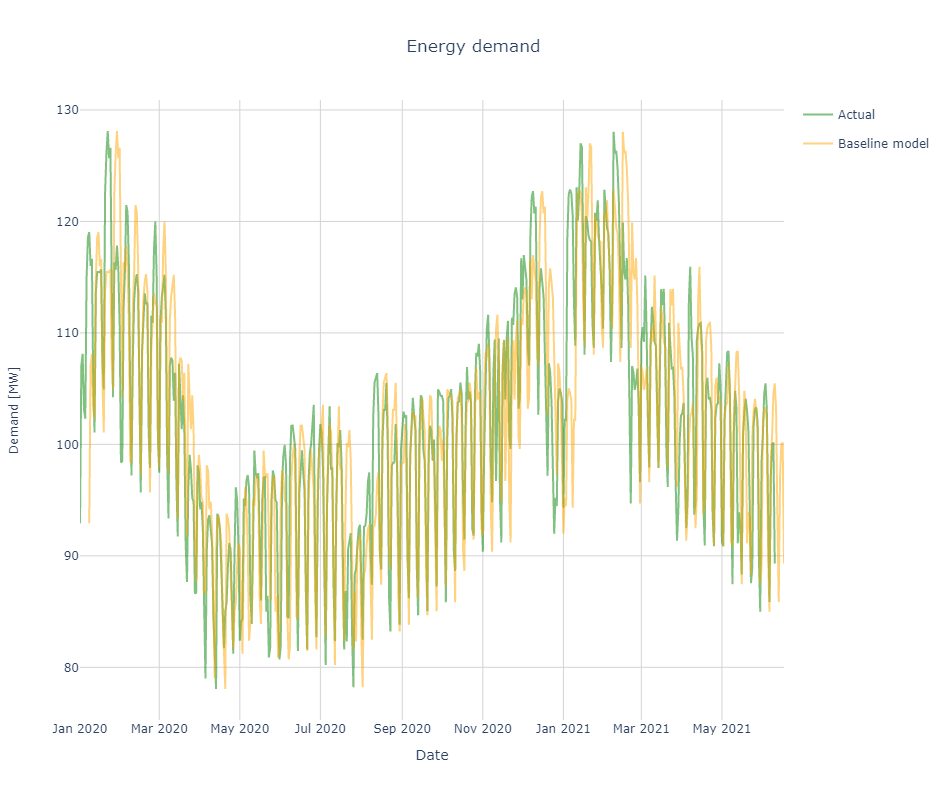

In [42]:
# Plot next to each other
fig = plot_figure_load(df)

# Plot baseline prediction
fig.add_trace(
    go.Scatter(
        x=df_load_baseline.index,
        y=df_load_baseline["baseline"],
        name="Baseline model",
        legendgroup="Baseline model",
        showlegend=True,
        line_color="orange",
        opacity=0.5,
    ),
    col=1,
    row=1,
)

## 1B. ML model

In [43]:
# add seasonal features
df['hour'] = df.index.hour
df['quarter_of_day'] = 6
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

In [44]:
from workalendar.europe import Netherlands
cal = Netherlands(include_carnival=True)

In [45]:
# Make a pandas series with holidays of interest
holidates = cal.holidays(2020) + cal.holidays(2021) + cal.holidays(2022)
pd_holidays = pd.to_datetime([d[0] for d in holidates])

In [48]:
df = df.assign(is_holiday=lambda d: d.index.isin(pd_holidays)).loc[lambda d: d['is_holiday']]

In [49]:
def add_fourier_features(df, column_name, period, n, period_name = "f"):
    t = df[column_name]
    for i in range(n):
        j = math.ceil((i+1)/2)
        if i%2:
            df[f'{period_name}_{i}'] = np.cos(j * 2 * np.pi * t / period)
        else:
            df[f'{period_name}_{i}'] = np.sin(j * 2 * np.pi * t / period)
    return df

In [50]:
def create_workday_weekend_features(df, fourier_order):
    # split features in workday / weekend
    df['is_workday'] = (~(df.is_holiday.astype(bool) | (df.day_of_week == 5) | (df.day_of_week == 6)))
    workday_data = {
        f'workday_{k}':df[k]*df.is_workday.astype(int)
        for k
        in ['temperature', 'solar_ghi'] + [f'f_quarter_{f}' for f in range(fourier_order)]
    }
    weekend_data = {
        f'weekend_{k}':df[k]*(~df.is_workday).astype(int)
        for k
        in ['temperature', 'solar_ghi'] + [f'f_quarter_{f}' for f in range(fourier_order)]
    }
    return workday_data, weekend_data

In [51]:
# add Fourier features to capture daily pattern in model
fourier_order = 6

df = add_fourier_features(df, "quarter_of_day", 4 * 24, fourier_order, "f_quarter")

In [52]:
# split workdays and weekend/holidays
workday_data, weekend_data = create_workday_weekend_features(df, fourier_order)
df_linregr = pd.DataFrame(
    {**workday_data, **weekend_data, "load": df["load_actuals_mw"]}
)

In [53]:
# List the input feature columns
feat_columns = list(workday_data.keys()) + list(weekend_data.keys())

In [54]:
# Define size of train and test set of model
number_of_training_days = 30
number_of_test_days = 30

test_start_date_run_i = df_linregr.index.min() + datetime.timedelta(
    days=number_of_training_days
)
test_end_date = df_linregr.index.max()
df_result = pd.DataFrame()

# Run model for full period of data set
while True:
    print(f"Start of prediction of this run: {test_start_date_run_i}")

    # split train/test set
    df_train = df_linregr[
        test_start_date_run_i
        - datetime.timedelta(days=number_of_training_days) : test_start_date_run_i
    ]

    df_test = df_linregr[
        test_start_date_run_i : test_start_date_run_i
        + datetime.timedelta(days=number_of_test_days)
    ]

    lr = LinearRegression()
    lr.fit(df_train[feat_columns], df_train["load"])
    
    y_pred = lr.predict(df_test[feat_columns])
    
    # Combine results
    df_result_run_i = pd.DataFrame(
        {
            "load": df_test["load"],
            "pred": y_pred,
        }
    )

    # Store results in a single dataframe
    df_result = df_result.append(df_result_run_i)
    # Adjust start date of test set for next run
    test_start_date_run_i = test_start_date_run_i + datetime.timedelta(
        days=number_of_test_days
    )
    if test_start_date_run_i > test_end_date:
        break 

Start of prediction of this run: 2020-01-31 00:00:00


<IPython.core.display.Javascript object>

Start of prediction of this run: 2020-03-01 00:00:00


<IPython.core.display.Javascript object>

ValueError: Found array with 0 sample(s) (shape=(0, 16)) while a minimum of 1 is required.